In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import argparse
from fer import FER2013
from torchvision import models

from torch.autograd import Variable
import torchvision
import transforms as transforms
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, precision_recall_curve
from torchvision import models
import h5py

In [10]:
# Configure the plotting aesthetics
sns.set(style='whitegrid')

# Define class names for confusion matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap='Blues'):  # Use a 'crest' color palette (pale colors)
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()

In [4]:
class Opt:
    model = 'EfficientNetB0'
    dataset = 'FER2013'
    split = 'Validation'

opt = Opt()

# Model
net = models.efficientnet_b0(pretrained=True)  
net.classifier[1] = nn.Linear(net.classifier[1].in_features, 7)

# Load the checkpoint
path = os.path.join(opt.dataset + '_' + opt.model)
checkpoint = torch.load(os.path.join(path, opt.split + '_model.t7'), map_location=torch.device('cpu'))

net.load_state_dict(checkpoint['net'])
net.eval()

# Data transformation
cut_size = 44
transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

# Load the dataset 
Testset = FER2013(split=opt.split, transform=transform_test)
Testloader = torch.utils.data.DataLoader(Testset, batch_size=128, shuffle=False, num_workers=0)

F:\FER-2013 Project\facialexpressionrecogination\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\FER-2013 Project\facialexpressionrecogination\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\USER\AppData\Local\Temp\ipykernel_3408\174258123.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickl

In [5]:
# Calculate predictions and targets
correct = 0
total = 0
all_targets = []
all_predicted = []

for batch_idx, (inputs, targets) in enumerate(Testloader):
    bs, ncrops, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    inputs, targets = Variable(inputs), Variable(targets)
    
    with torch.no_grad():
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)
        _, predicted = torch.max(outputs_avg.data, 1)

    total += targets.size(0)
    correct += predicted.eq(targets.data).sum().item()

    all_predicted.extend(predicted.numpy())
    all_targets.extend(targets.numpy())

# Accuracy
acc = 100. * correct / total
print(f"Accuracy: {acc:.3f}%")

F:\FER-2013 Project\fer2013_vgg_resnet\transforms\functional.py:63: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


Accuracy: 67.958%


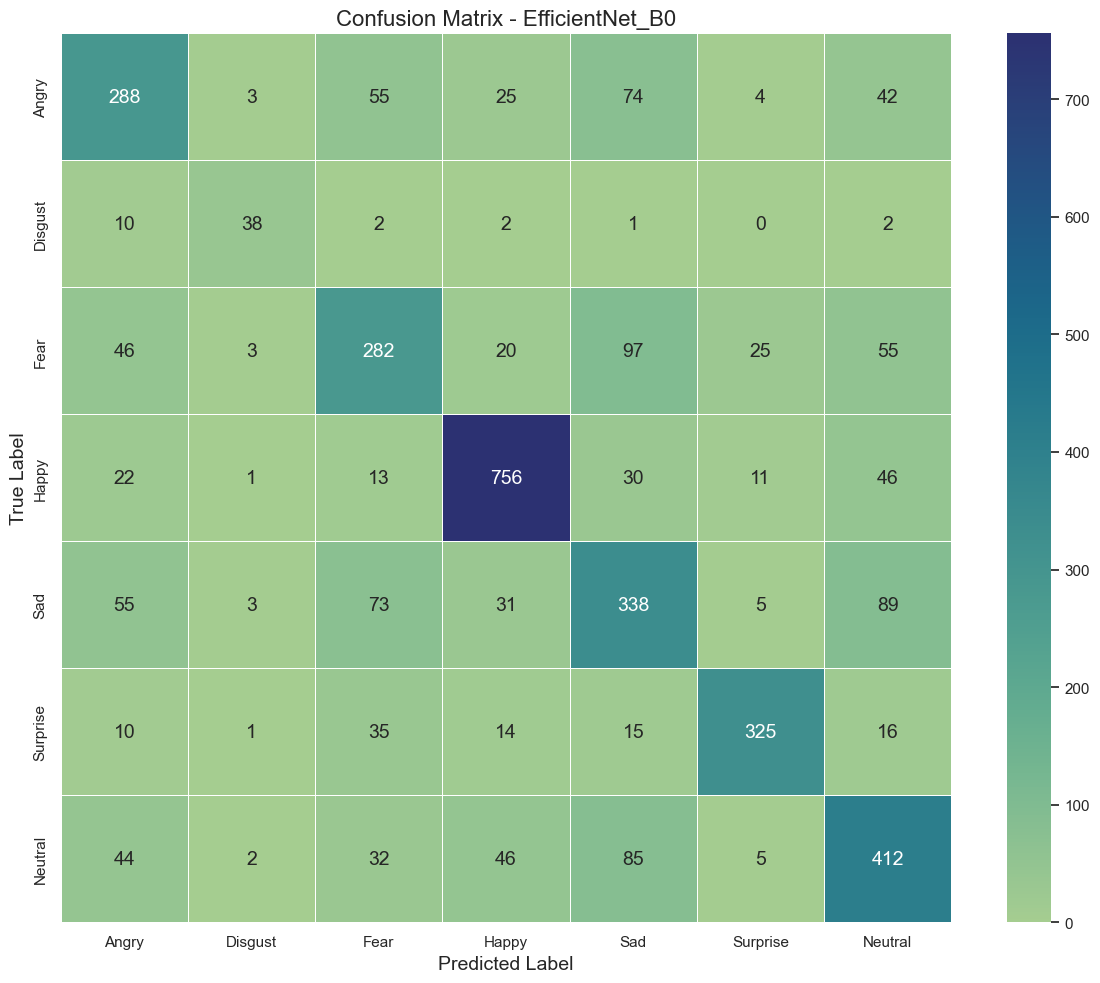

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

# Example of a custom color palette (you can choose another one from the list above)
cmap = sns.color_palette("crest", as_cmap=True)  # Soft blue gradient

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes,
                cbar=True, linewidths=0.5, annot_kws={"size": 14})
    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_predicted)

# Plot confusion matrix with aesthetic color palette
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix - EfficientNet_B0', cmap=cmap)
plt.savefig(os.path.join(path, opt.split + '_cm.png'))
plt.show()

Normalized confusion matrix


<Figure size 1000x800 with 0 Axes>

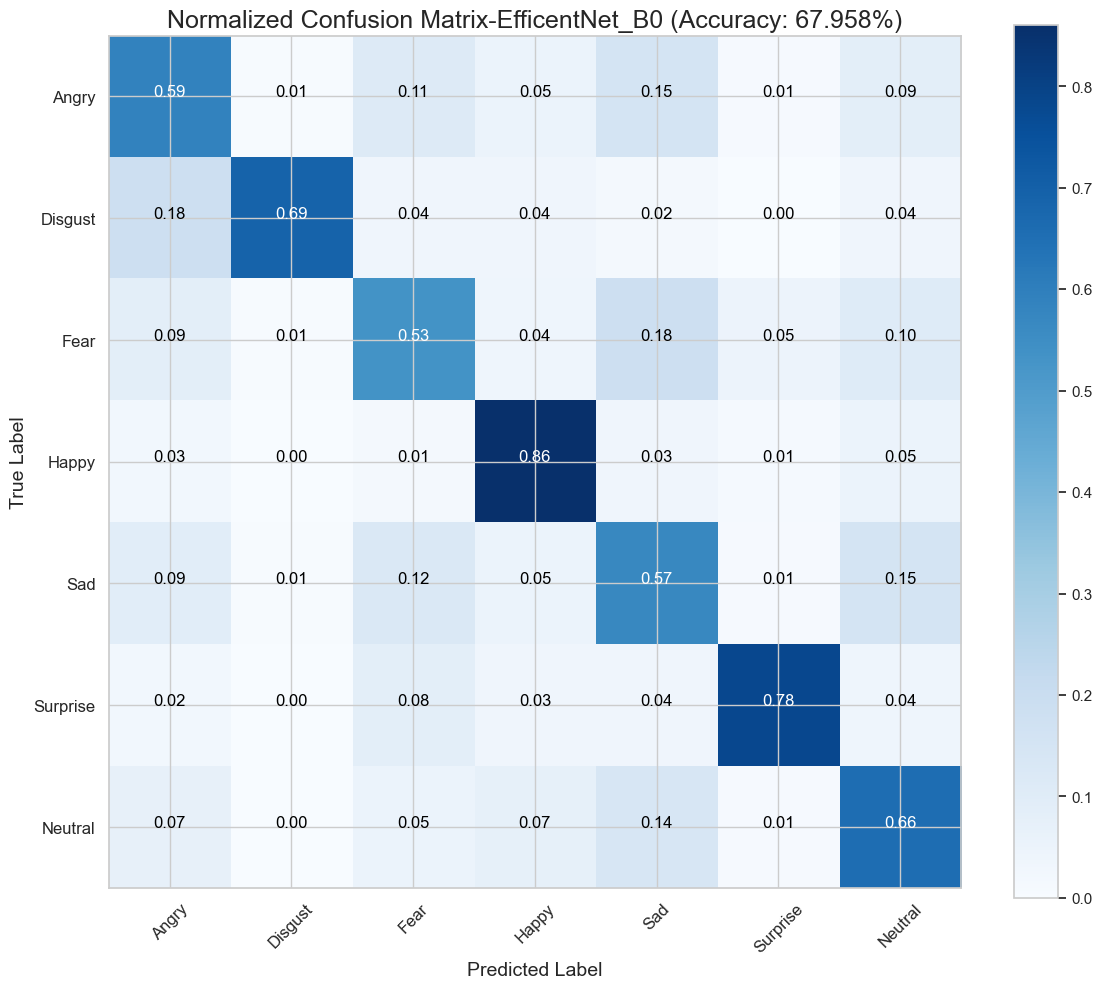

In [31]:
# Compute confusion matrix
matrix = confusion_matrix(all_targets, all_predicted)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title=f'Normalized Confusion Matrix-EfficentNet_B0 (Accuracy: {acc:.3f}%)')
plt.savefig(os.path.join(path, opt.split + '_NormalizedConfusionMatrix.png'))
plt.show()

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tabulate import tabulate
import os

# Generate classification report
report = classification_report(all_targets, all_predicted, target_names=class_names, output_dict=True)

# Convert to a DataFrame for processing
report_df = pd.DataFrame(report).transpose()

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_predicted)

# Class-wise accuracy: Accuracy = TP / (TP + FP + FN)
class_accuracies = []

for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True positives (diagonal elements)
    fp = cm[:, i].sum() - tp  # False positives (sum of column - diagonal element)
    fn = cm[i, :].sum() - tp  # False negatives (sum of row - diagonal element)
    
    # Class-wise accuracy (True Positives / (True Positives + False Positives + False Negatives))
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) != 0 else 0
    class_accuracies.append(accuracy)

# Print or save class accuracies
print("Class-wise accuracies:")
for class_name, accuracy in zip(class_names, class_accuracies):
    print(f"{class_name}: {accuracy:.2f}")

# Calculate overall average metrics
average_metrics = {
    'Precision': report_df.loc['macro avg', 'precision'],
    'Recall': report_df.loc['macro avg', 'recall'],
    'F1-Score': report_df.loc['macro avg', 'f1-score'],
    'Accuracy': report['accuracy'],
    'Support': int(report_df['support'].sum())
}

# Prepare the table
# Add class-wise accuracy to the table
table = []
for idx, class_name in enumerate(class_names):
    metrics = report[class_name]
    table.append([
        class_name, 
        metrics['precision'], 
        metrics['recall'], 
        metrics['f1-score'], 
        metrics['support'], 
        class_accuracies[idx]  # Use class accuracy here
    ])

# Add the overall average row
table.append([
    'Average',
    average_metrics['Precision'],
    average_metrics['Recall'],
    average_metrics['F1-Score'],
    average_metrics['Support'],
    average_metrics['Accuracy']
])

# Print the table
print(tabulate(table, headers=['Class', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'], floatfmt='.2f'))

# Save the classification report as a CSV file
classification_report_path = os.path.join(path, f'{opt.split}_classification_report.csv')
report_df.to_csv(classification_report_path, index=True)

# Save the custom table as a text file
classification_report_text_path = os.path.join(path, f'{opt.split}_classification_report_custom.txt')
with open(classification_report_text_path, 'w') as f:
    f.write(tabulate(table, headers=['Class', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'], floatfmt='.2f'))

Class-wise accuracies:
Angry: 0.42
Disgust: 0.56
Fear: 0.38
Happy: 0.74
Sad: 0.38
Surprise: 0.70
Neutral: 0.47
Class       Precision    Recall    F1-Score    Support    Accuracy
--------  -----------  --------  ----------  ---------  ----------
Angry            0.61      0.59        0.60     491.00        0.42
Disgust          0.75      0.69        0.72      55.00        0.56
Fear             0.57      0.53        0.55     528.00        0.38
Happy            0.85      0.86        0.85     879.00        0.74
Sad              0.53      0.57        0.55     594.00        0.38
Surprise         0.87      0.78        0.82     416.00        0.70
Neutral          0.62      0.66        0.64     626.00        0.47
Average          0.68      0.67        0.68   10767.00        0.68


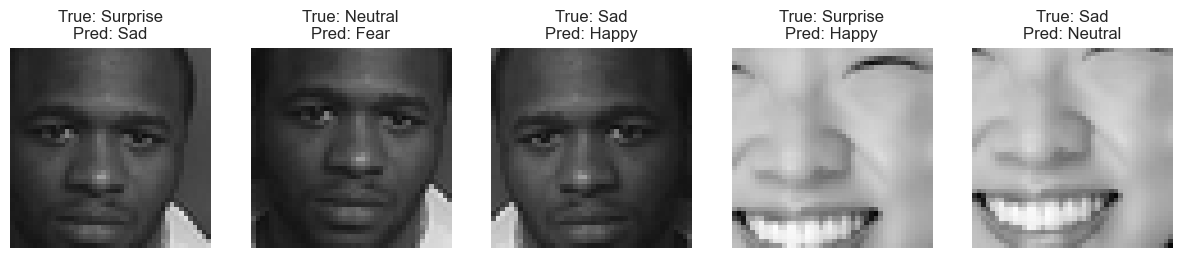

In [13]:
# Identify incorrect predictions
incorrect_indices = [i for i, (target, pred) in enumerate(zip(all_targets, all_predicted)) if target != pred]
num_samples = min(len(incorrect_indices), 5)  # Display a few samples

plt.figure(figsize=(15, 15))
for i in range(num_samples):
    idx = incorrect_indices[i]
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(inputs[idx].permute(1, 2, 0).cpu().numpy())
    plt.title(f'True: {class_names[all_targets[idx]]}\nPred: {class_names[all_predicted[idx]]}')
    plt.axis('off')
    plt.savefig(os.path.join(path, opt.split + '_incorrect_predictions.png'))
plt.show()

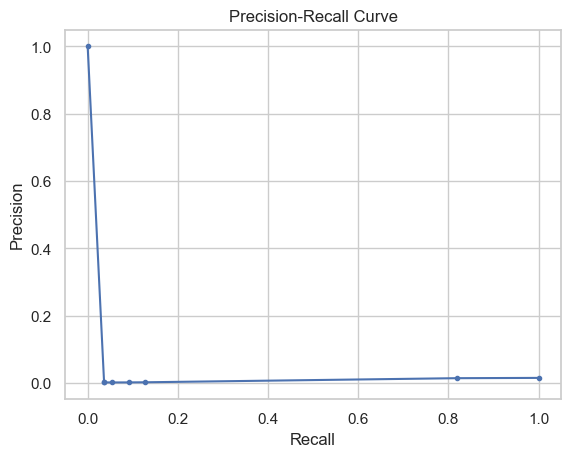

In [14]:
precision, recall, _ = precision_recall_curve(all_targets, all_predicted, pos_label=1)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig(os.path.join(path, opt.split + '_PrecisionRecallCurve.png'))
plt.show()

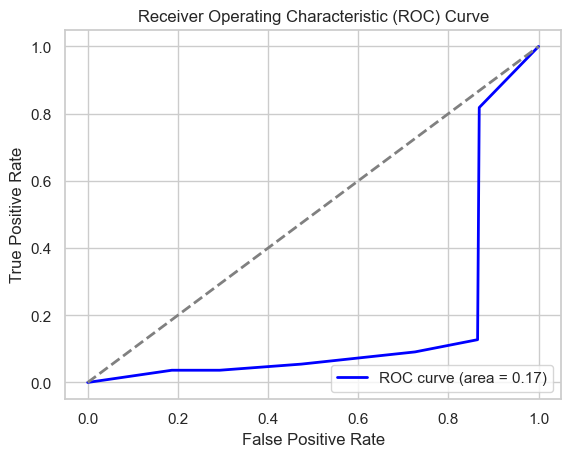

In [15]:
fpr, tpr, _ = roc_curve(all_targets, all_predicted, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(os.path.join(path, opt.split + '_ReceiverOperatingCharacteristics.png'))
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_3408\3775531915.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


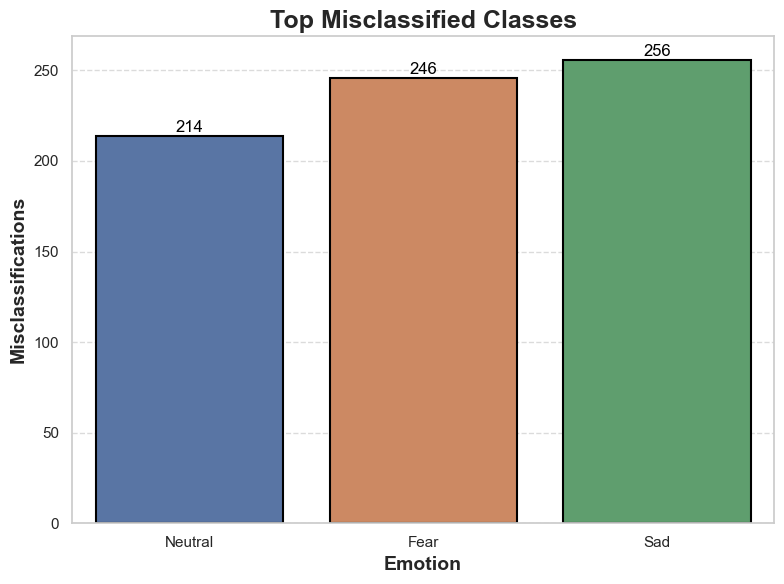

In [16]:
# Top misclassified classes
misclassified = cm - np.diag(np.diag(cm))
misclassified_counts = np.sum(misclassified, axis=1)
misclassified_classes = [class_names[i] for i in np.argsort(misclassified_counts)[-3:]]

plt.figure(figsize=(8, 6))

# Plot using the default Seaborn color palette
ax = sns.barplot(
    x=misclassified_classes, 
    y=np.sort(misclassified_counts)[-3:], 
    palette="deep"  # Ensures the default Seaborn color palette
)

# Add data labels
for i, value in enumerate(np.sort(misclassified_counts)[-3:]):
    ax.text(i, value + 0.5, f'{int(value)}', ha='center', va='bottom', fontsize=12, color='black')

# Customize the appearance
plt.title("Top Misclassified Classes", fontsize=18, fontweight='bold')
plt.ylabel("Misclassifications", fontsize=14, fontweight='bold')
plt.xlabel("Emotion", fontsize=14, fontweight='bold')

# Add horizontal gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add black edges around the bars
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1.5)

plt.tight_layout()
# Save the plot
plt.savefig(os.path.join(path, f'{opt.split}_top_misclassified_classes.png'))
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_3408\1624720946.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


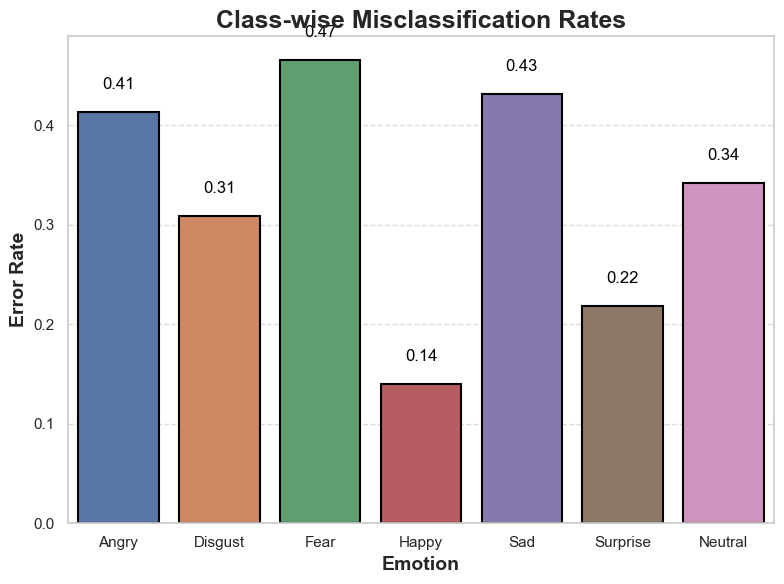

In [17]:
# Class-wise Misclassification Rates
misclassification_rate = 1 - np.diag(cm) / np.sum(cm, axis=1)

plt.figure(figsize=(8, 6))

# Plot using the default Seaborn color palette
ax = sns.barplot(
    x=class_names, 
    y=misclassification_rate, 
    palette="deep"  # Ensures the default Seaborn color palette
)

# Add data labels
for i, value in enumerate(misclassification_rate):
    ax.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12, color='black')

# Customize the appearance
plt.title("Class-wise Misclassification Rates", fontsize=18, fontweight='bold')
plt.ylabel("Error Rate", fontsize=14, fontweight='bold')
plt.xlabel("Emotion", fontsize=14, fontweight='bold')

# Add horizontal gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add black edges around the bars
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1.5)

plt.tight_layout()
# Save the plot
plt.savefig(os.path.join(path, f'{opt.split}_class_wise_error_rates.png'))
plt.show()

In [18]:
# Load metrics.csv
metrics_path = r"F:\FER-2013 Project\fer2013_vgg_resnet\FER2013_EfficientNetB0\metrics.csv"
output_folder = os.path.dirname(metrics_path)
data = pd.read_csv(metrics_path)

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

In [19]:
# Helper function to save plots
def save_plot(fig, filename):
    filepath = os.path.join(output_folder, filename)
    fig.savefig(filepath, bbox_inches='tight')
    plt.close(fig)

In [20]:
def plot_metrics_over_epochs(data, metric_prefix):
    """
    Plot metrics (Accuracy, Loss, Precision, Recall, F1) over epochs for the given prefix (Train, Testing, Validation).

    Args:
        data (DataFrame): DataFrame containing the metrics.
        metric_prefix (str): Prefix for the metrics (e.g., 'Train', 'Testing', 'Validation').
    """
    metrics = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1']  # Added Accuracy and Loss
    for metric in metrics:
        metric_col = f"{metric_prefix} {metric}"
        if metric_col not in data.columns:
            raise KeyError(f"'{metric_col}' column not found in the DataFrame.")

        fig, ax = plt.subplots()
        ax.plot(data['Epoch'], data[metric_col], marker='o', label=metric_col)
        ax.set_title(f'{metric_prefix} {metric} Over Epochs')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric)
        ax.legend()
        save_plot(fig, f'{metric_prefix.lower()}_{metric.lower()}_over_epochs.png')

# Example usage:
plot_metrics_over_epochs(data, "Train")
plot_metrics_over_epochs(data, "Testing")
plot_metrics_over_epochs(data, "Validation")

In [27]:
# Normalize metrics for Training
data['Train Accuracy Normalized'] = (data['Train Accuracy'] - data['Train Accuracy'].min()) / (data['Train Accuracy'].max() - data['Train Accuracy'].min())
data['Train Precision Normalized'] = (data['Train Precision'] - data['Train Precision'].min()) / (data['Train Precision'].max() - data['Train Precision'].min())
data['Train F1 Normalized'] = (data['Train F1'] - data['Train F1'].min()) / (data['Train F1'].max() - data['Train F1'].min())
data['Train Recall Normalized'] = (data['Train Recall'] - data['Train Recall'].min()) / (data['Train Recall'].max() - data['Train Recall'].min())

# Normalize metrics for Testing
data['Test Accuracy Normalized'] = (data['Testing Accuracy'] - data['Testing Accuracy'].min()) / (data['Testing Accuracy'].max() - data['Testing Accuracy'].min())
data['Test Precision Normalized'] = (data['Testing Precision'] - data['Testing Precision'].min()) / (data['Testing Precision'].max() - data['Testing Precision'].min())
data['Test F1 Normalized'] = (data['Testing F1'] - data['Testing F1'].min()) / (data['Testing F1'].max() - data['Testing F1'].min())
data['Test Recall Normalized'] = (data['Testing Recall'] - data['Testing Recall'].min()) / (data['Testing Recall'].max() - data['Testing Recall'].min())

# Normalize metrics for Validation
data['Validation Accuracy Normalized'] = (data['Validation Accuracy'] - data['Validation Accuracy'].min()) / (data['Validation Accuracy'].max() - data['Validation Accuracy'].min())
data['Validation Precision Normalized'] = (data['Validation Precision'] - data['Validation Precision'].min()) / (data['Validation Precision'].max() - data['Validation Precision'].min())
data['Validation F1 Normalized'] = (data['Validation F1'] - data['Validation F1'].min()) / (data['Validation F1'].max() - data['Validation F1'].min())
data['Validation Recall Normalized'] = (data['Validation Recall'] - data['Validation Recall'].min()) / (data['Validation Recall'].max() - data['Validation Recall'].min())


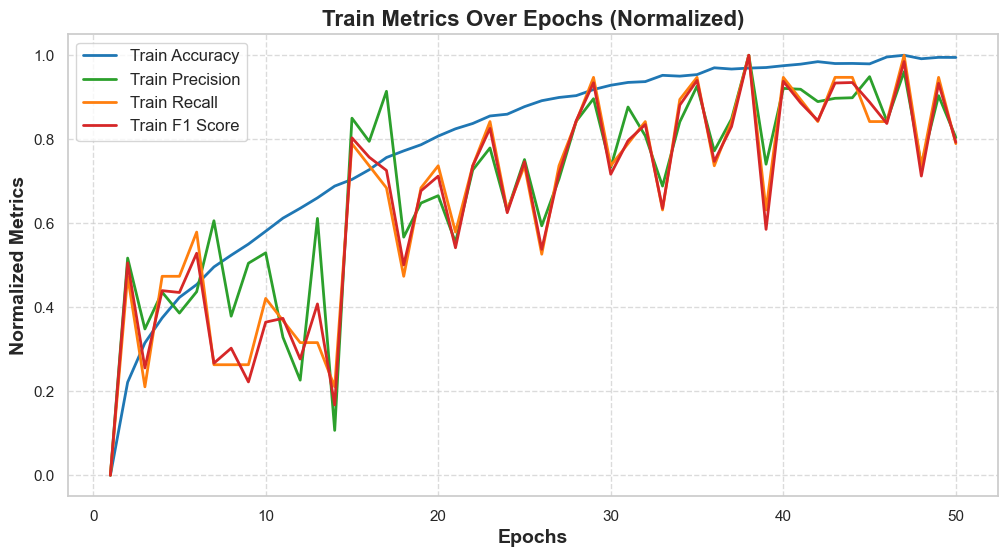

In [28]:
# Updated function
def plot_training_metrics(data, ax):
    """
    Plot combined Accuracy, Precision, Recall, and F1 Score for Training metrics.
    Args:
        data (DataFrame): DataFrame containing the metrics.
        ax (axes): Matplotlib axis object to plot the graph on.
    """
    # Define custom colors for aesthetics
    colors = {
        'accuracy': '#1f77b4',  # Blue
        'precision': '#2ca02c',  # Green
        'recall': '#ff7f0e',  # Orange
        'f1': '#d62728'  # Red
    }

    ax.plot(data['Epoch'], data['Train Accuracy Normalized'], label='Train Accuracy', linestyle='-', color=colors['accuracy'], linewidth=2)
    ax.plot(data['Epoch'], data['Train Precision Normalized'], label='Train Precision', linestyle='-', color=colors['precision'], linewidth=2)
    ax.plot(data['Epoch'], data['Train Recall Normalized'], label='Train Recall', linestyle='-', color=colors['recall'], linewidth=2)
    ax.plot(data['Epoch'], data['Train F1 Normalized'], label='Train F1 Score', linestyle='-', color=colors['f1'], linewidth=2)

    ax.set_xlabel('Epochs', fontsize=14, fontweight='bold')
    ax.set_ylabel('Normalized Metrics', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=12)
    ax.set_title('Train Metrics Over Epochs (Normalized)', fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)

# Example usage
fig, ax = plt.subplots(figsize=(12, 6))
plot_training_metrics(data, ax)

# Save the Training plot
fig.savefig(os.path.join(output_folder, 'train_metrics_normalized_over_epochs.png'), bbox_inches='tight')

# Show the plot
plt.show()

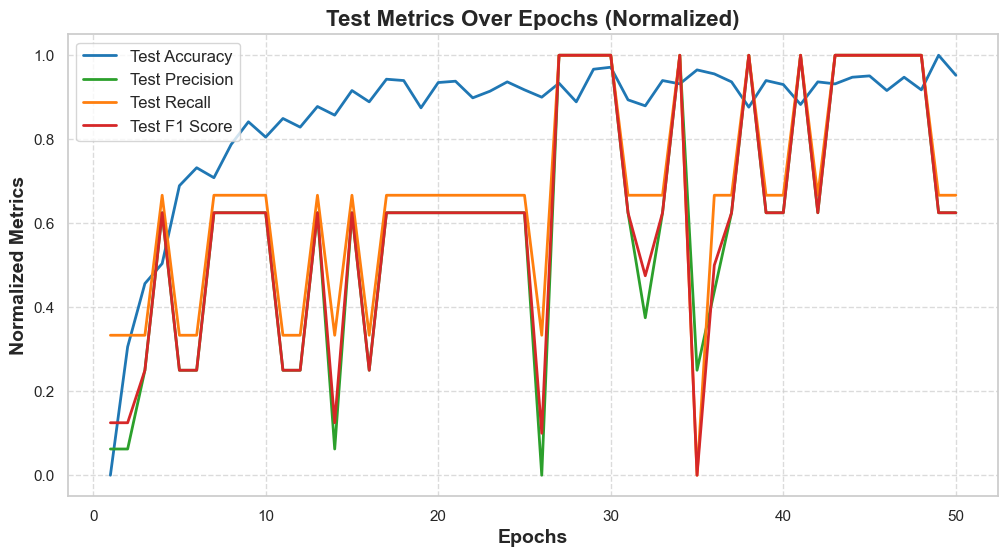

In [29]:
# Updated function
def plot_testing_metrics(data, ax):
    """
    Plot combined Accuracy, Precision, Recall, and F1 Score for Testing metrics.
    Args:
        data (DataFrame): DataFrame containing the metrics.
        ax (axes): Matplotlib axis object to plot the graph on.
    """
    # Define custom colors for aesthetics
    colors = {
        'accuracy': '#1f77b4',  # Blue
        'precision': '#2ca02c',  # Green
        'recall': '#ff7f0e',  # Orange
        'f1': '#d62728'  # Red
    }

    ax.plot(data['Epoch'], data['Test Accuracy Normalized'], label='Test Accuracy', linestyle='-', color=colors['accuracy'], linewidth=2)
    ax.plot(data['Epoch'], data['Test Precision Normalized'], label='Test Precision', linestyle='-', color=colors['precision'], linewidth=2)
    ax.plot(data['Epoch'], data['Test Recall Normalized'], label='Test Recall', linestyle='-', color=colors['recall'], linewidth=2)
    ax.plot(data['Epoch'], data['Test F1 Normalized'], label='Test F1 Score', linestyle='-', color=colors['f1'], linewidth=2)

    ax.set_xlabel('Epochs', fontsize=14, fontweight='bold')
    ax.set_ylabel('Normalized Metrics', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=12)
    ax.set_title('Test Metrics Over Epochs (Normalized)', fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)

# Create a figure and axis for Testing Metrics
fig, ax = plt.subplots(figsize=(12, 6))

# Plot for Testing Metrics
plot_testing_metrics(data, ax)

# Save the Testing plot
fig.savefig(os.path.join(output_folder, 'test_metrics_normalized_over_epochs.png'), bbox_inches='tight')

# Show the plot
plt.show()


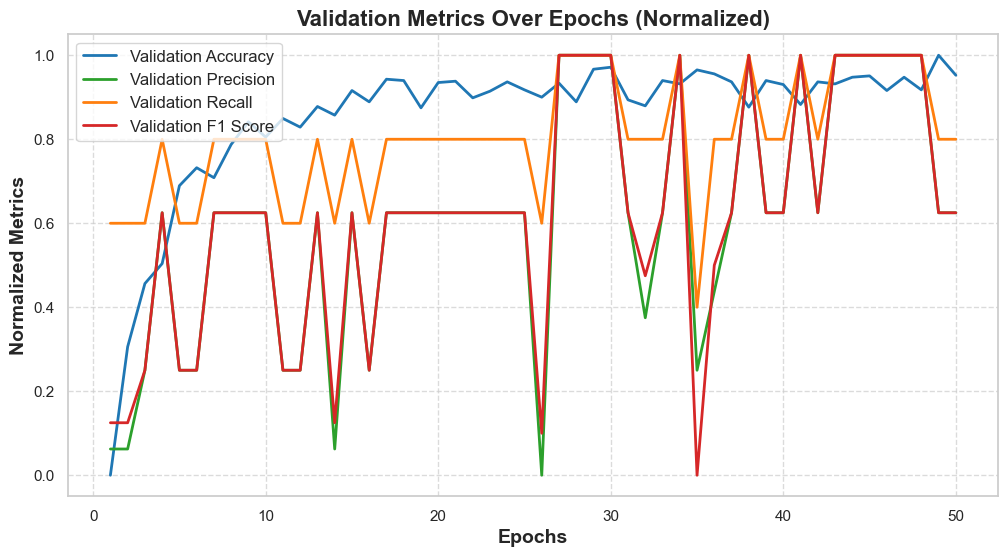

In [30]:
# Updated function
def plot_validation_metrics(data, ax):
    """
    Plot combined Accuracy, Precision, Recall, and F1 Score for Validation metrics.
    Args:
        data (DataFrame): DataFrame containing the metrics.
        ax (axes): Matplotlib axis object to plot the graph on.
    """
    # Define custom colors for aesthetics
    colors = {
        'accuracy': '#1f77b4',  # Blue
        'precision': '#2ca02c',  # Green
        'recall': '#ff7f0e',  # Orange
        'f1': '#d62728'  # Red
    }

    ax.plot(data['Epoch'], data['Val Accuracy Normalized'], label='Validation Accuracy', linestyle='-', color=colors['accuracy'], linewidth=2)
    ax.plot(data['Epoch'], data['Val Precision Normalized'], label='Validation Precision', linestyle='-', color=colors['precision'], linewidth=2)
    ax.plot(data['Epoch'], data['Val Recall Normalized'], label='Validation Recall', linestyle='-', color=colors['recall'], linewidth=2)
    ax.plot(data['Epoch'], data['Val F1 Normalized'], label='Validation F1 Score', linestyle='-', color=colors['f1'], linewidth=2)

    ax.set_xlabel('Epochs', fontsize=14, fontweight='bold')
    ax.set_ylabel('Normalized Metrics', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=12)
    ax.set_title('Validation Metrics Over Epochs (Normalized)', fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)

# Create a figure and axis for Validation Metrics
fig, ax = plt.subplots(figsize=(12, 6))

# Plot for Validation Metrics
plot_validation_metrics(data, ax)

# Save the Validation plot
fig.savefig(os.path.join(output_folder, 'validation_metrics_normalized_over_epochs.png'), bbox_inches='tight')

# Show the plot
plt.show()

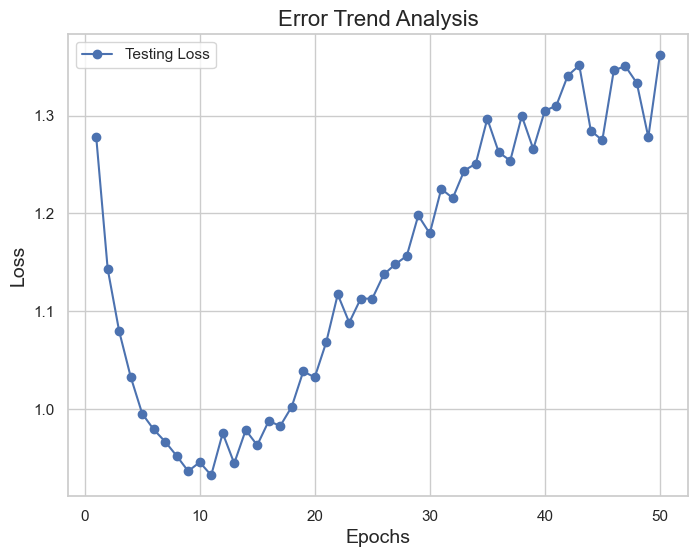

In [45]:
# Error Trend Analysis: Epoch vs Testing Loss
plt.figure(figsize=(8, 6))
plt.plot(data['Epoch'], data['Testing Loss'], marker='o', label='Testing Loss')
plt.title('Error Trend Analysis', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.savefig(os.path.join(path, f'{opt.split}_error_trend_analysis.png'))
plt.show()

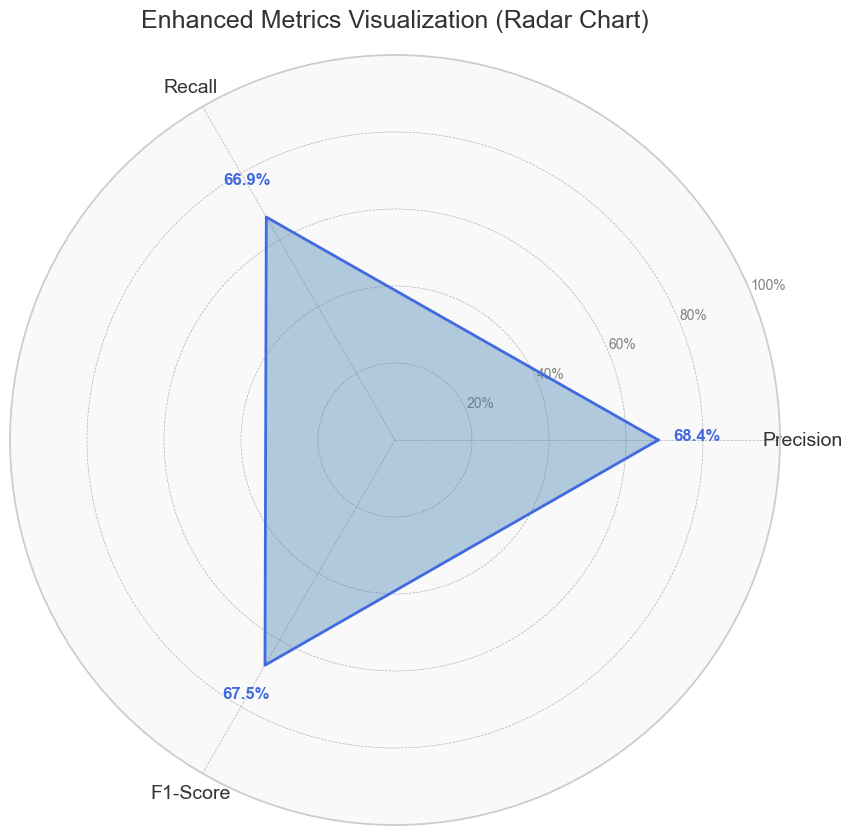

Enhanced radar chart saved to FER2013_EfficientNetB0\whole_dataset_radar_chart.png


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define metrics for the radar chart
metrics = ['Precision', 'Recall', 'F1-Score']

# Calculate the mean of metrics across all classes
radar_data = report_df.loc[:, ['precision', 'recall', 'f1-score']].iloc[:-3].mean().values  # Exclude summary rows

# Prepare angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
radar_data = np.concatenate((radar_data, [radar_data[0]]))  # Close the loop
angles += angles[:1]

# Set up the radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
ax.set_facecolor('#f9f9f9')  # Light gray background
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

# Fill and plot the radar chart
ax.fill(angles, radar_data, color='#4682B4', alpha=0.4)  # Steel blue fill
ax.plot(angles, radar_data, color='#4169E1', linewidth=2)  # Royal blue line

# Add aesthetic touches
ax.set_yticks(np.arange(0.2, 1.1, 0.2))  # Custom radial ticks
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], color='gray', fontsize=10)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=14, color='#333333')  # Bold labels
ax.set_title('Enhanced Metrics Visualization (Radar Chart)', fontsize=18, color='#333333', pad=20)

# Highlight key metrics
for i, angle in enumerate(angles[:-1]):
    ax.text(
        angle, radar_data[i] + 0.1, f"{radar_data[i]*100:.1f}%",
        horizontalalignment='center', color='#4169E1', fontsize=12, weight='bold'
    )

# Save and display the radar chart
save_path = os.path.join(path, f'whole_dataset_radar_chart.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='#f9f9f9')
plt.show()

print(f"Enhanced radar chart saved to {save_path}")

C:\Users\USER\AppData\Local\Temp\ipykernel_2384\2660394721.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=class_names, y=values, palette='viridis')


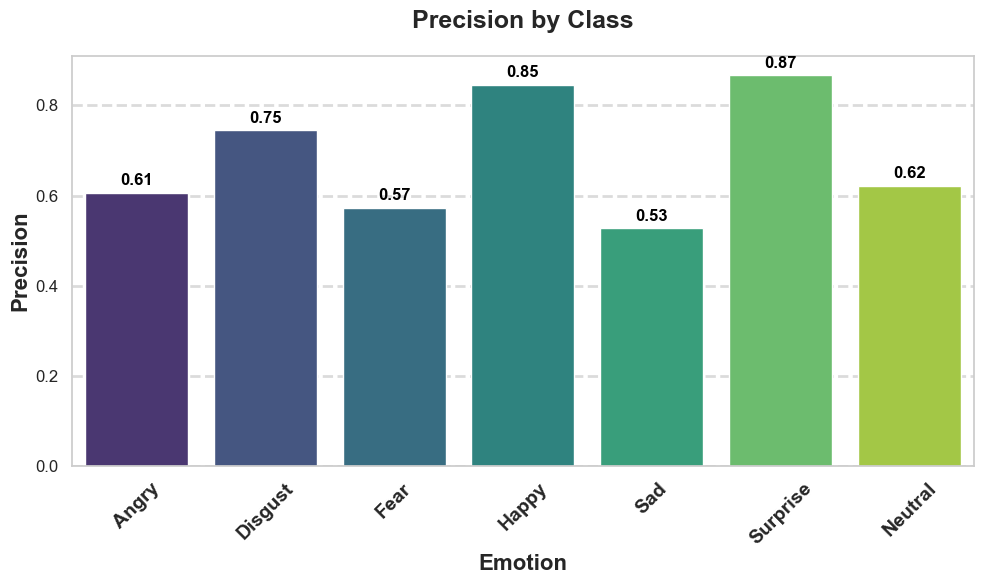

Precision bar chart saved to FER2013_EfficientNetB0\Validation_precision_by_class.png


C:\Users\USER\AppData\Local\Temp\ipykernel_2384\2660394721.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=class_names, y=values, palette='viridis')


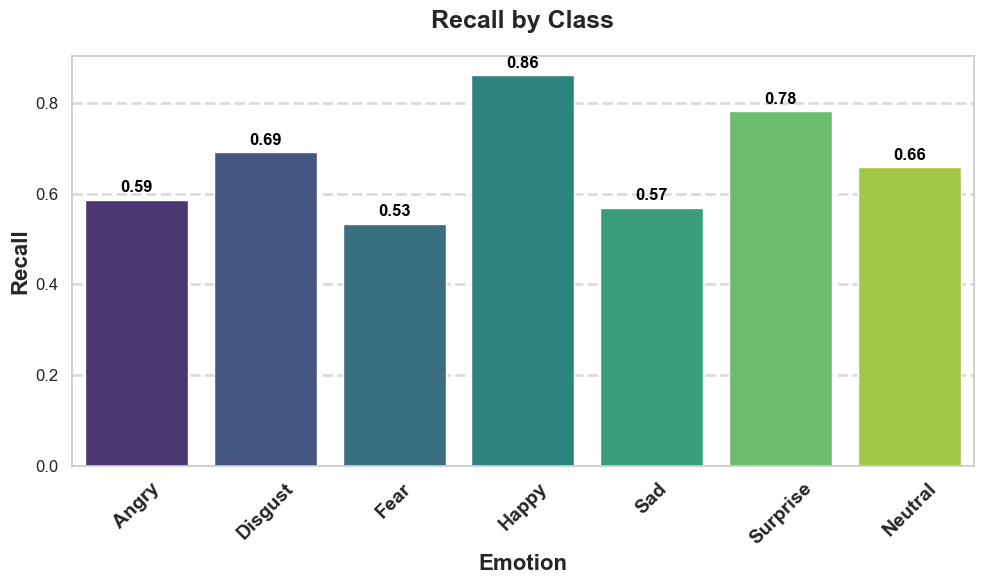

Recall bar chart saved to FER2013_EfficientNetB0\Validation_recall_by_class.png


C:\Users\USER\AppData\Local\Temp\ipykernel_2384\2660394721.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=class_names, y=values, palette='viridis')


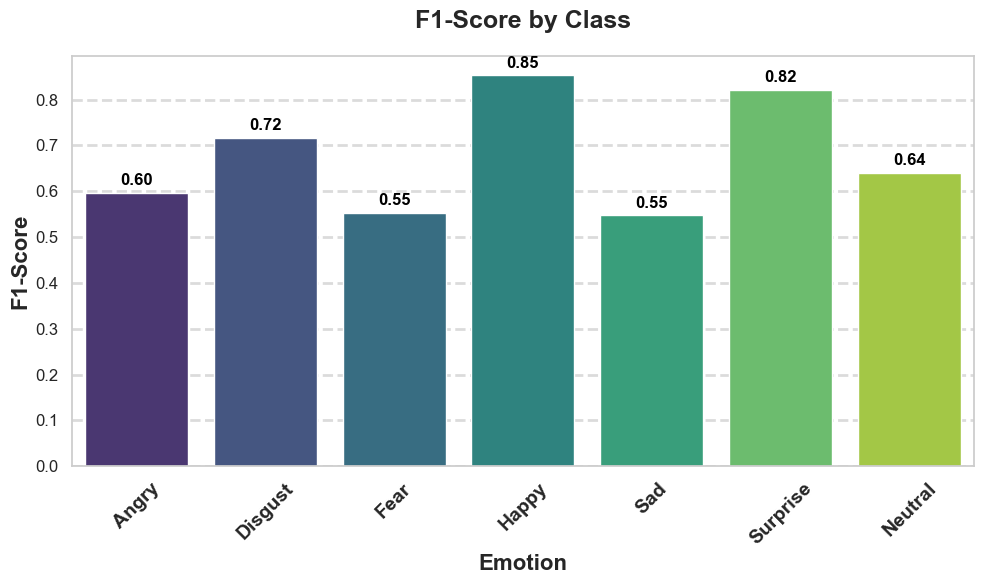

F1-Score bar chart saved to FER2013_EfficientNetB0\Validation_f1-score_by_class.png


C:\Users\USER\AppData\Local\Temp\ipykernel_2384\2660394721.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=class_names, y=values, palette='viridis')


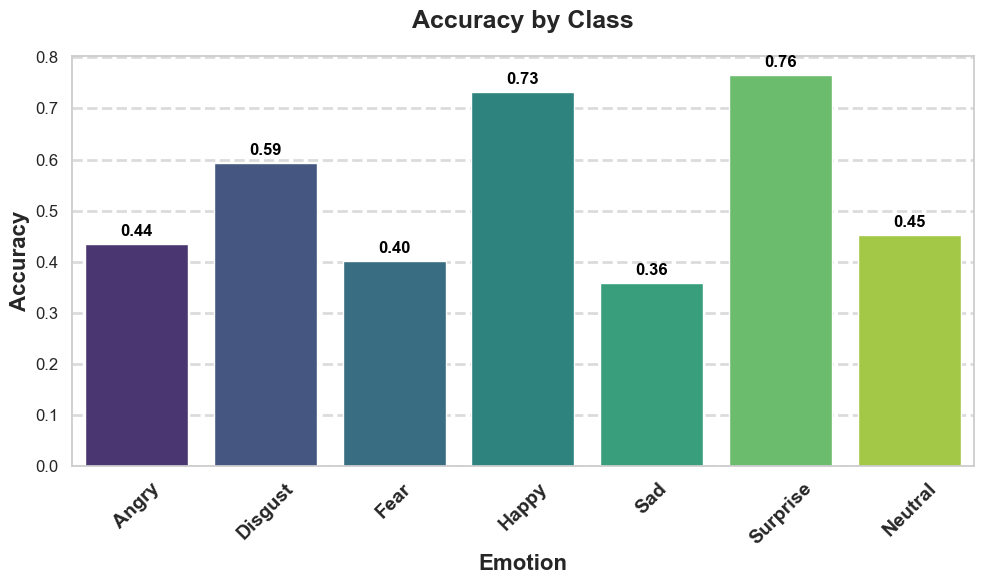

Accuracy bar chart saved to FER2013_EfficientNetB0\Validation_accuracy_by_class.png


C:\Users\USER\AppData\Local\Temp\ipykernel_2384\2660394721.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=class_names, y=values, palette='viridis')


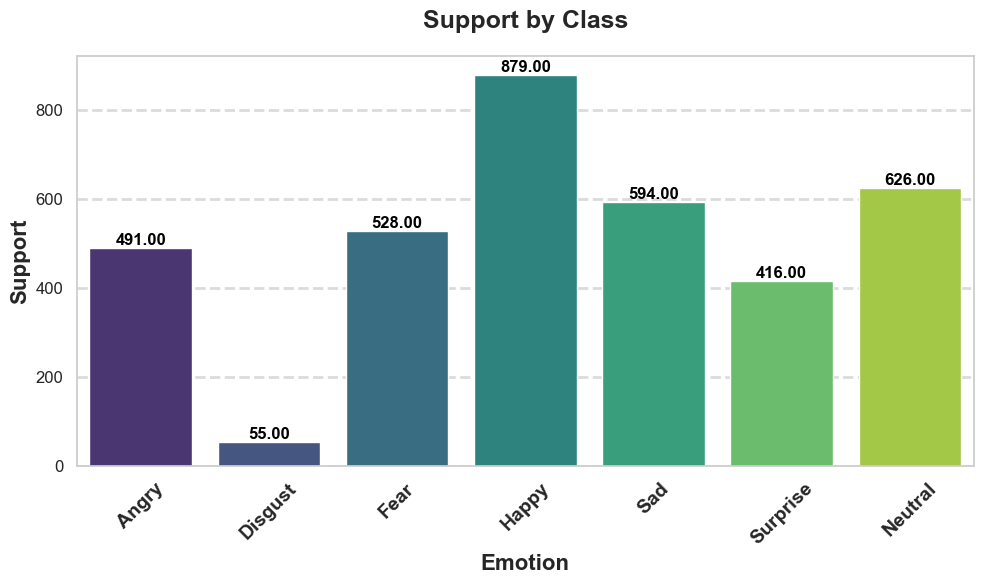

Support bar chart saved to FER2013_EfficientNetB0\Validation_support_by_class.png


In [66]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Calculate individual class accuracy (TP / (TP + FP + FN))
class_accuracies = []
for class_name in class_names:
    tp = report_df.loc[class_name, 'precision'] * report_df.loc[class_name, 'support']
    fn = report_df.loc[class_name, 'support'] - tp
    recall = report_df.loc[class_name, 'recall']
    fp = (tp / report_df.loc[class_name, 'precision']) - tp if report_df.loc[class_name, 'precision'] != 0 else 0
    tn = report_df['support'].sum() - (tp + fp + fn)
    
    # Correcting class accuracy formula
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) != 0 else 0  # Correct formula
    class_accuracies.append(accuracy)

# Create a DataFrame for accuracies and ensure alignment with class rows
accuracy_df = pd.DataFrame({'accuracy_per_class': class_accuracies}, index=class_names)

# Define all metrics to visualize
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'Support']

# Loop through each metric and generate bar charts
for metric in metrics:
    plt.figure(figsize=(10, 6))
    
    # Use calculated accuracies for 'Accuracy' metric
    if metric.lower() == 'accuracy':
        values = accuracy_df['accuracy_per_class'].values  # Use calculated accuracies
    elif metric.lower() == 'support':
        values = report_df.loc[class_names, 'support'].values
    else:
        values = report_df.loc[class_names, metric.lower()].values
    
    # Plot the bar chart with distinct markers and thicker lines
    bar_plot = sns.barplot(x=class_names, y=values, palette='viridis')
    
    # Add data labels (accuracy values) above each bar
    for i, v in enumerate(values):
        bar_plot.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
    
    # Title, labels, and gridlines enhancements
    plt.title(f'{metric} by Class', fontsize=18, fontweight='bold', pad=20)
    plt.ylabel(metric, fontsize=16, fontweight='bold')
    plt.xlabel('Emotion', fontsize=16, fontweight='bold')
    
    # Rotate class labels and style them
    plt.xticks(rotation=45, fontsize=14, fontweight='bold')  
    plt.yticks(fontsize=12)
    
    # Add gridlines with dashed lines
    plt.grid(axis='y', linestyle='--', linewidth=2, alpha=0.7)
    
    # Tight layout for neat saving
    plt.tight_layout()

    # Save the chart
    save_path = os.path.join(path, f'{opt.split}_{metric.lower()}_by_class.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"{metric} bar chart saved to {save_path}")

C:\Users\USER\AppData\Local\Temp\ipykernel_2384\2558211138.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Average', data=average_metrics_df, palette='viridis')


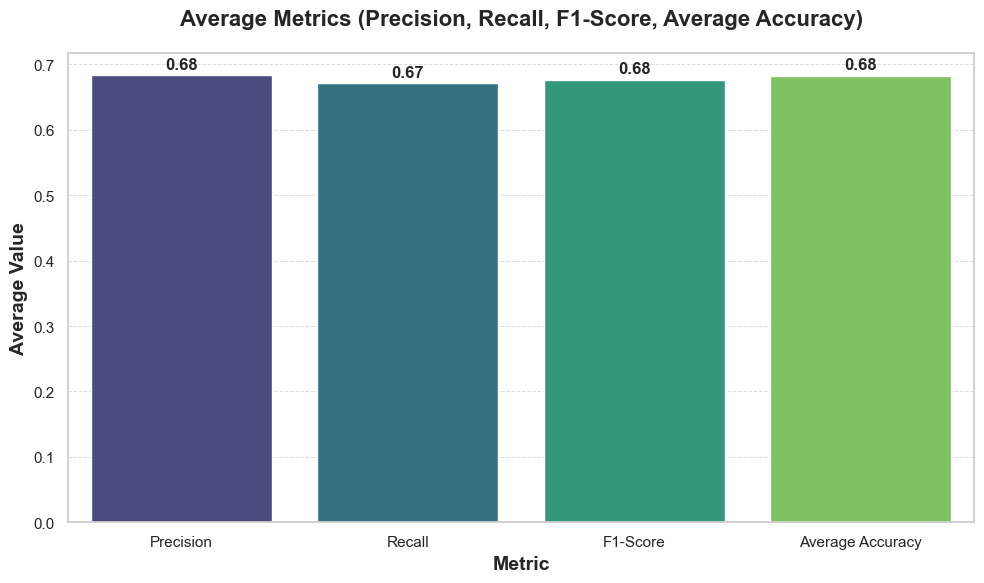

Average metrics chart saved to FER2013_EfficientNetB0\Validation_average_metrics.png


In [70]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Calculate averages for precision, recall, f1-score, and accuracy
avg_precision = report_df['precision'].mean()
avg_recall = report_df['recall'].mean()
avg_f1_score = report_df['f1-score'].mean()

# Calculate average accuracy: (sum of precision * support) / total support
total_precision_support = (report_df['precision'] * report_df['support']).sum()
total_support = report_df['support'].sum()
avg_accuracy = total_precision_support / total_support

# Store all average metrics in a dictionary
average_metrics = {
    'Precision': avg_precision,
    'Recall': avg_recall,
    'F1-Score': avg_f1_score,
    'Average Accuracy': avg_accuracy
}

# Convert dictionary to a DataFrame for easier plotting
average_metrics_df = pd.DataFrame(list(average_metrics.items()), columns=['Metric', 'Average'])

# Plotting the average metrics
plt.figure(figsize=(10, 6))

# Use seaborn to create the bar plot
sns.barplot(x='Metric', y='Average', data=average_metrics_df, palette='viridis')

# Add title and labels
plt.title('Average Metrics (Precision, Recall, F1-Score, Average Accuracy)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Metric', fontsize=14, fontweight='bold')
plt.ylabel('Average Value', fontsize=14, fontweight='bold')

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Display the value on top of each bar
for index, value in enumerate(average_metrics_df['Average']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', fontsize=12, fontweight='bold')

# Tight layout to prevent clipping
plt.tight_layout()

# Save the plot
save_path = os.path.join(path, f'{opt.split}_average_metrics.png')
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()
print(f"Average metrics chart saved to {save_path}")

In [21]:
 # Function to generate misclassification report
def generate_misclassification_report(cm, class_names):
    """
    Generate a detailed misclassification report from the confusion matrix.
    
    Args:
        cm (ndarray): Confusion matrix.
        class_names (list): List of class names.

    Returns:
        DataFrame: Misclassification details with true and predicted classes.
    """
    misclassification_data = []
    for i, true_class in enumerate(class_names):
        for j, predicted_class in enumerate(class_names):
            if i != j and cm[i, j] > 0:  # Only include misclassifications
                misclassification_data.append({
                    "True Class": true_class,
                    "Predicted Class": predicted_class,
                    "Count": cm[i, j]
                })
    
    return pd.DataFrame(misclassification_data)

# Generate misclassification report
misclassification_report = generate_misclassification_report(cm, class_names)

# Save the misclassification report
misclassification_report_path = os.path.join(path, f'{opt.split}_misclassification_report.csv')
misclassification_report.to_csv(misclassification_report_path, index=False)
print(f"Misclassification report saved at {misclassification_report_path}")

Misclassification report saved at FER2013_EfficientNetB0\Validation_misclassification_report.csv


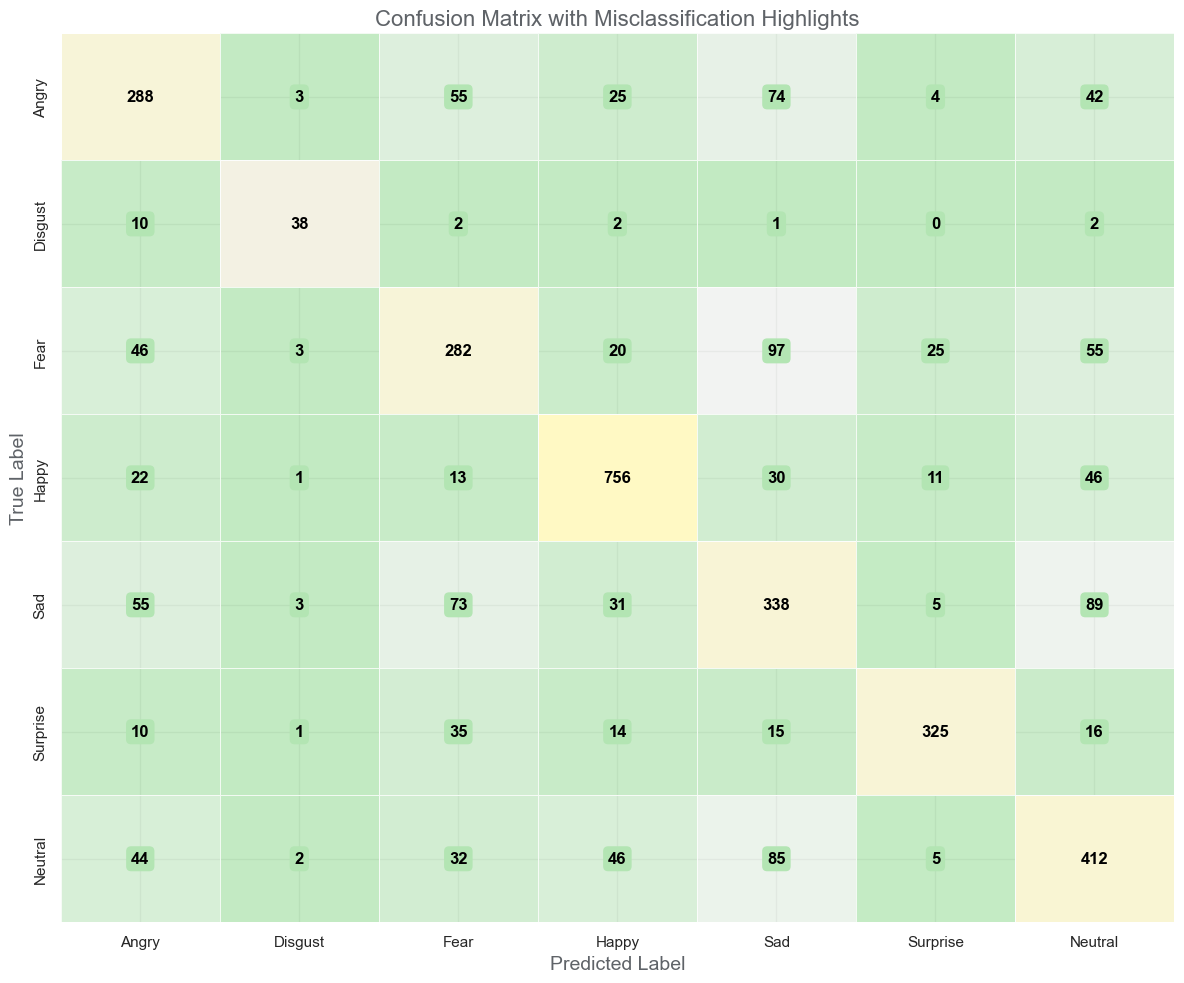

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def plot_misclassification_matrix(cm, class_names, save_path):
    """
    Plot a confusion matrix with aesthetic improvements and enhanced misclassification highlights.

    Args:
        cm (ndarray): Confusion matrix.
        class_names (list): List of class names.
        save_path (str): Path to save the plotted confusion matrix.
    """
    plt.figure(figsize=(12, 10))

    # Custom pastel color maps for diagonal and off-diagonal cells
    cmap_correct = sns.light_palette("#FFF9C4", as_cmap=True)  # Pastel yellow for correct
    cmap_wrong = sns.light_palette("#B3E5B3", as_cmap=True, reverse=True)  # Pastel green for misclassified

    # Create a mask to differentiate correct from misclassified
    mask_correct = np.eye(len(cm), dtype=bool)

    # Base heatmap with pastel colors
    sns.heatmap(cm, annot=False, fmt='d', cmap=cmap_correct, mask=~mask_correct,
                xticklabels=class_names, yticklabels=class_names, cbar=False, linewidths=0.5)
    sns.heatmap(cm, annot=False, fmt='d', cmap=cmap_wrong, mask=mask_correct,
                xticklabels=class_names, yticklabels=class_names, cbar=False, linewidths=0.5, alpha=0.8)

    # Add annotations with improved contrast
    for i in range(len(cm)):
        for j in range(len(cm)):
            value = cm[i, j]
            # Text for correct classifications
            if i == j:
                plt.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', 
                         color='black', fontsize=12, fontweight='bold')
            # Text for misclassifications
            else:
                plt.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', 
                         color='black', fontsize=12, fontweight='bold',
                         bbox=dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="#B3E5B3"))

    # Titles and labels with soft pastel text
    plt.xlabel('Predicted Label', fontsize=14, color='#5F6368')  # Soft grey for labels
    plt.ylabel('True Label', fontsize=14, color='#5F6368')  # Soft grey for labels
    plt.title('Confusion Matrix with Misclassification Highlights', fontsize=16, color='#5F6368')  # Soft grey title
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

save_path =os.path.join(path, f'{opt.split}_misclassification_confusionMatrix.png')
plot_misclassification_matrix(cm, class_names, save_path)